# Introduction

In [3]:
# Suppress native-hadoop warning
!sed -i '$a\# Add the line for suppressing the NativeCodeLoader warning \nlog4j.logger.org.apache.hadoop.util.NativeCodeLoader=ERROR,console' /$HADOOP_HOME/etc/hadoop/log4j.properties

In [4]:
import sys
sys.path.append('/home/work')

In [5]:
import pyspark
from pyspark.sql import SparkSession, functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, count, desc

from data.utils.data_loader import load_from_hdfs

In [6]:
conf = pyspark.SparkConf()
settings = conf.getAll()

# Set Spark Settings
conf = pyspark.SparkConf().setAll([
('spark.master', 'local[*]'),
('spark.app.name', 'MusicRecommender'),
('spark.driver.memory','14g')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# Print the Spark Session settings
settings = spark.sparkContext.getConf().getAll()
for s in settings:
    print(s)

('spark.driver.port', '33295')
('spark.driver.host', 'dac583b3c46a')
('spark.executor.id', 'driver')
('spark.app.startTime', '1717048860509')
('spark.app.submitTime', '1717048860424')
('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useD

In [7]:
# Load the dataset
dataset = 'raw'
partitions = 10
train_data, test_data = load_from_hdfs(dataset, partitions)
# Cache the dataframes
train_data.cache()
test_data.cache()
# Uncomment to combine train and test into one dataframe
# total_dataset = train_data.union(test_data).cache()

DataFrame[user_id: int, song_id: int, rating: int, partition_id: int]

In [1]:
# Plot the distribution of ratings per user or the frequency of rating counts 
def boxplot_user_ratings_distribution(df, ax=None, partition=None):
    user_rating_counts = df.groupBy("user_id").count().sort("count")
    user_rating_counts = user_rating_counts.withColumnRenamed("count", "rating_count")
    
    # uncomment to show frequency of each rating count
    user_rating_counts = user_rating_counts.groupBy("rating_count").count()
    
    user_rating_counts = user_rating_counts.toPandas()
    if ax is None:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='rating_count', data=user_rating_counts)
        plt.title("User Ratings Distribution")
        plt.xlabel("Ratings")
        plt.ylabel("Users")
        plt.show()
    else:
        sns.boxplot(x="rating_count", data=user_rating_counts, ax=ax)
        ax.set_title(f"Partition {partition}")
        ax.set_xlabel("Ratings")
        ax.set_ylabel("Users")

def histplot_user_ratings_distribution(df, ax=None, partition=None):
    user_rating_counts = df.groupBy("user_id").count().sort("count")
    user_rating_counts = user_rating_counts.withColumnRenamed("count", "rating_count")
    
    # uncomment to show frequency of each rating count
    user_rating_counts = user_rating_counts.groupBy("rating_count").count()
    
    user_rating_counts = user_rating_counts.toPandas()
    if ax is None:
        plt.figure(figsize=(10, 6))
        sns.histplot(x='rating_count', data=user_rating_counts)
        plt.title("User Ratings Distribution")
        plt.xlabel("Ratings")
        plt.ylabel("Users")
        plt.show()
    else:
        sns.histplot(x="rating_count", data=user_rating_counts, ax=ax)
        ax.set_title(f"Partition {partition}")
        ax.set_xlabel("Ratings")
        ax.set_ylabel("Users")

# Plot the distribution of rating scores    
def barplot_rating_distribution(df, ax=None, partition=None):
    ratings = df.groupBy("rating").count().sort("rating")
    colors = sns.color_palette("RdYlGn", 5)
    ratings = ratings.toPandas()
    
    if ax is None:
        plt.figure(figsize=(10, 6))
        sns.barplot(x="rating", y="count", data=ratings, palette=colors)
        plt.title("Rating Distribution")
        plt.xlabel("Rating")
        plt.ylabel("Count")
        plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))
        plt.show()
    else:
        sns.barplot(x="rating", y="count", data=ratings, ax=ax, palette=colors)
        ax.set_title(f"Partition {partition}")
        ax.set_ylabel("Count")
        ax.set_xlabel("Rating")
        ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))
    

## User Rating Distribution

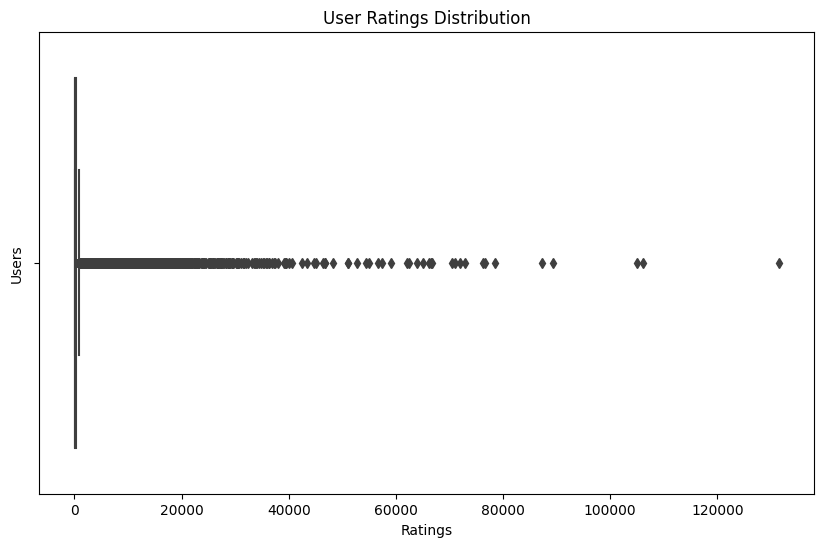

In [8]:
# Plot ratings per user distribution for the entire training set
boxplot_user_ratings_distribution(train_data)

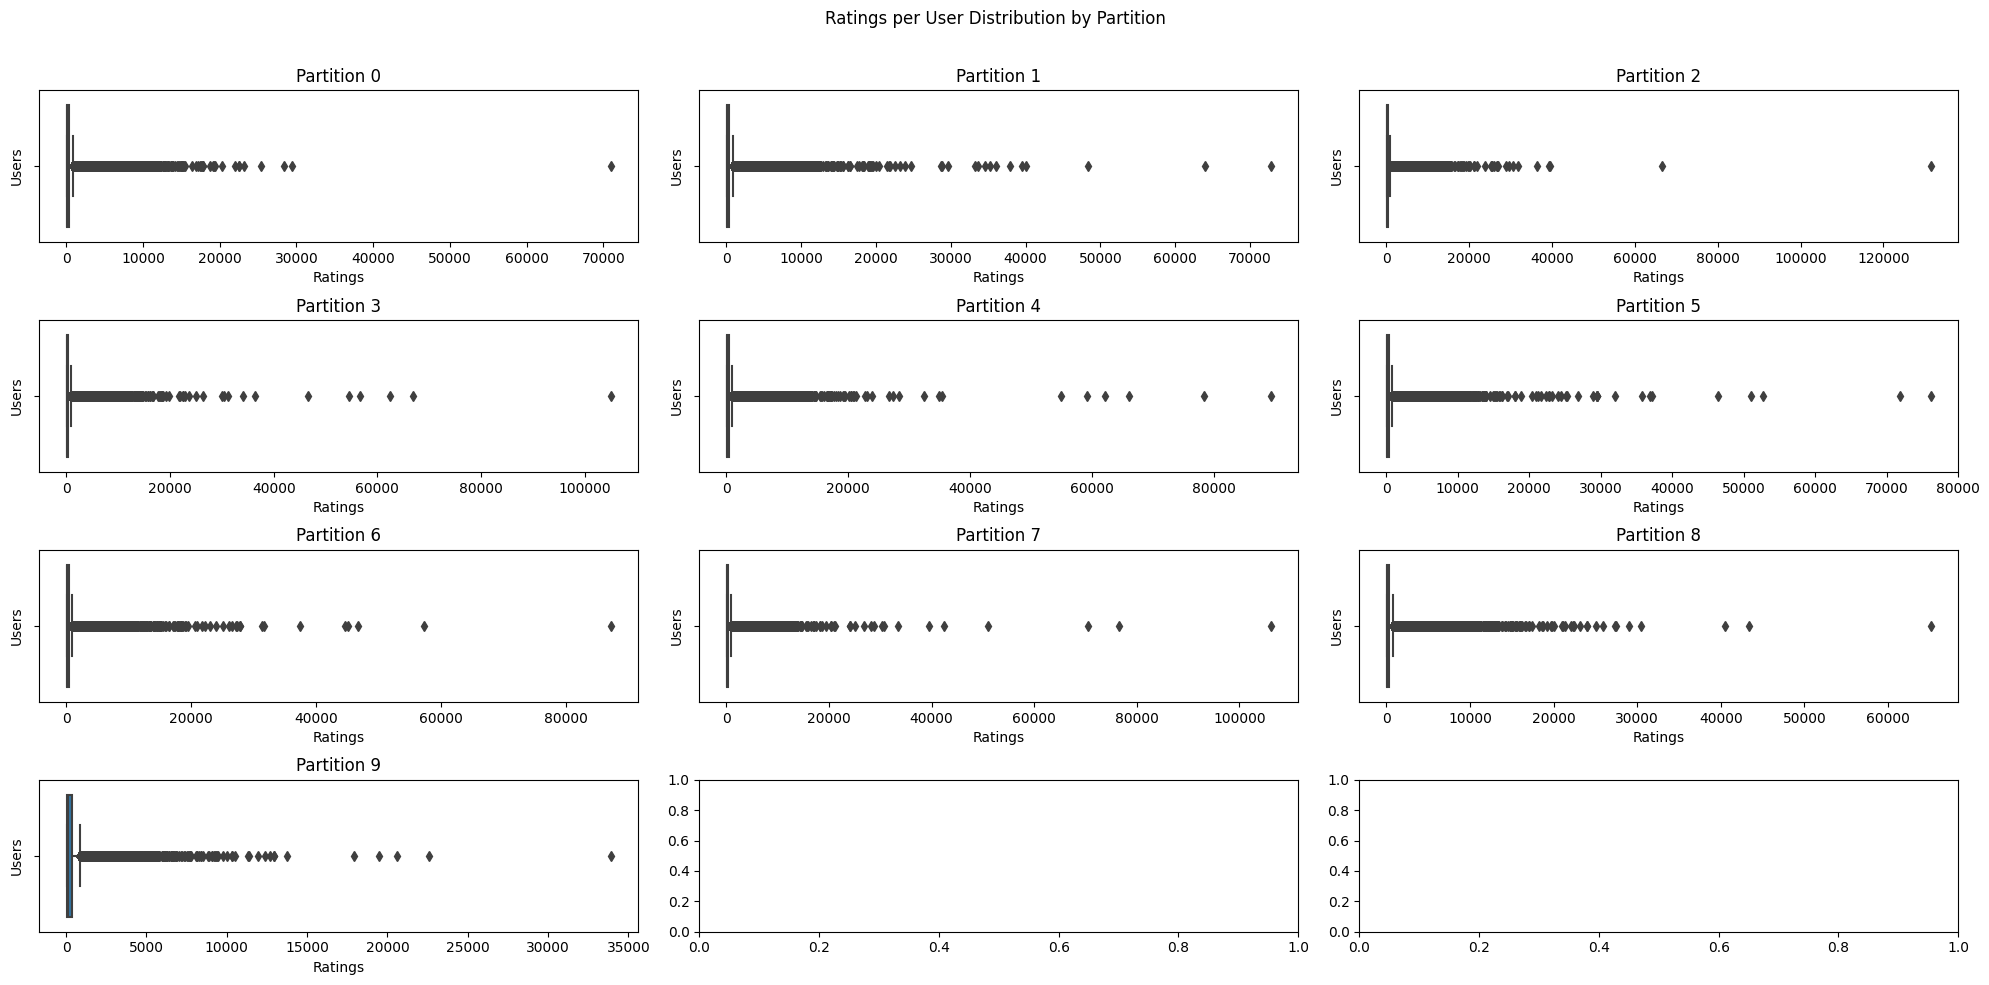

In [9]:
# plot_partitions = [i for i in range(partitions)]
maxCols = 3
rows = (partitions // maxCols) + 1

# Plot ratings per user distribution for each partition
fig, ax = plt.subplots(rows, maxCols, figsize=(20, 10))
fig.suptitle(f"Ratings per User Distribution by Partition")
for i in range(partitions):
    train_data_partition = train_data.filter(F.col("partition_id") == i)
    row = i // maxCols
    col = i % maxCols
    boxplot_user_ratings_distribution(train_data_partition, ax=ax[row, col], partition=i)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


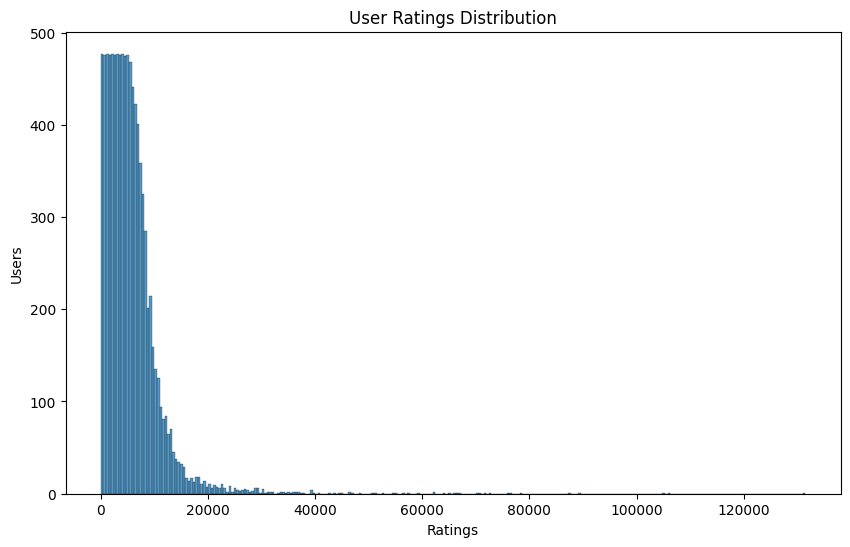

In [8]:
histplot_user_ratings_distribution(train_data)

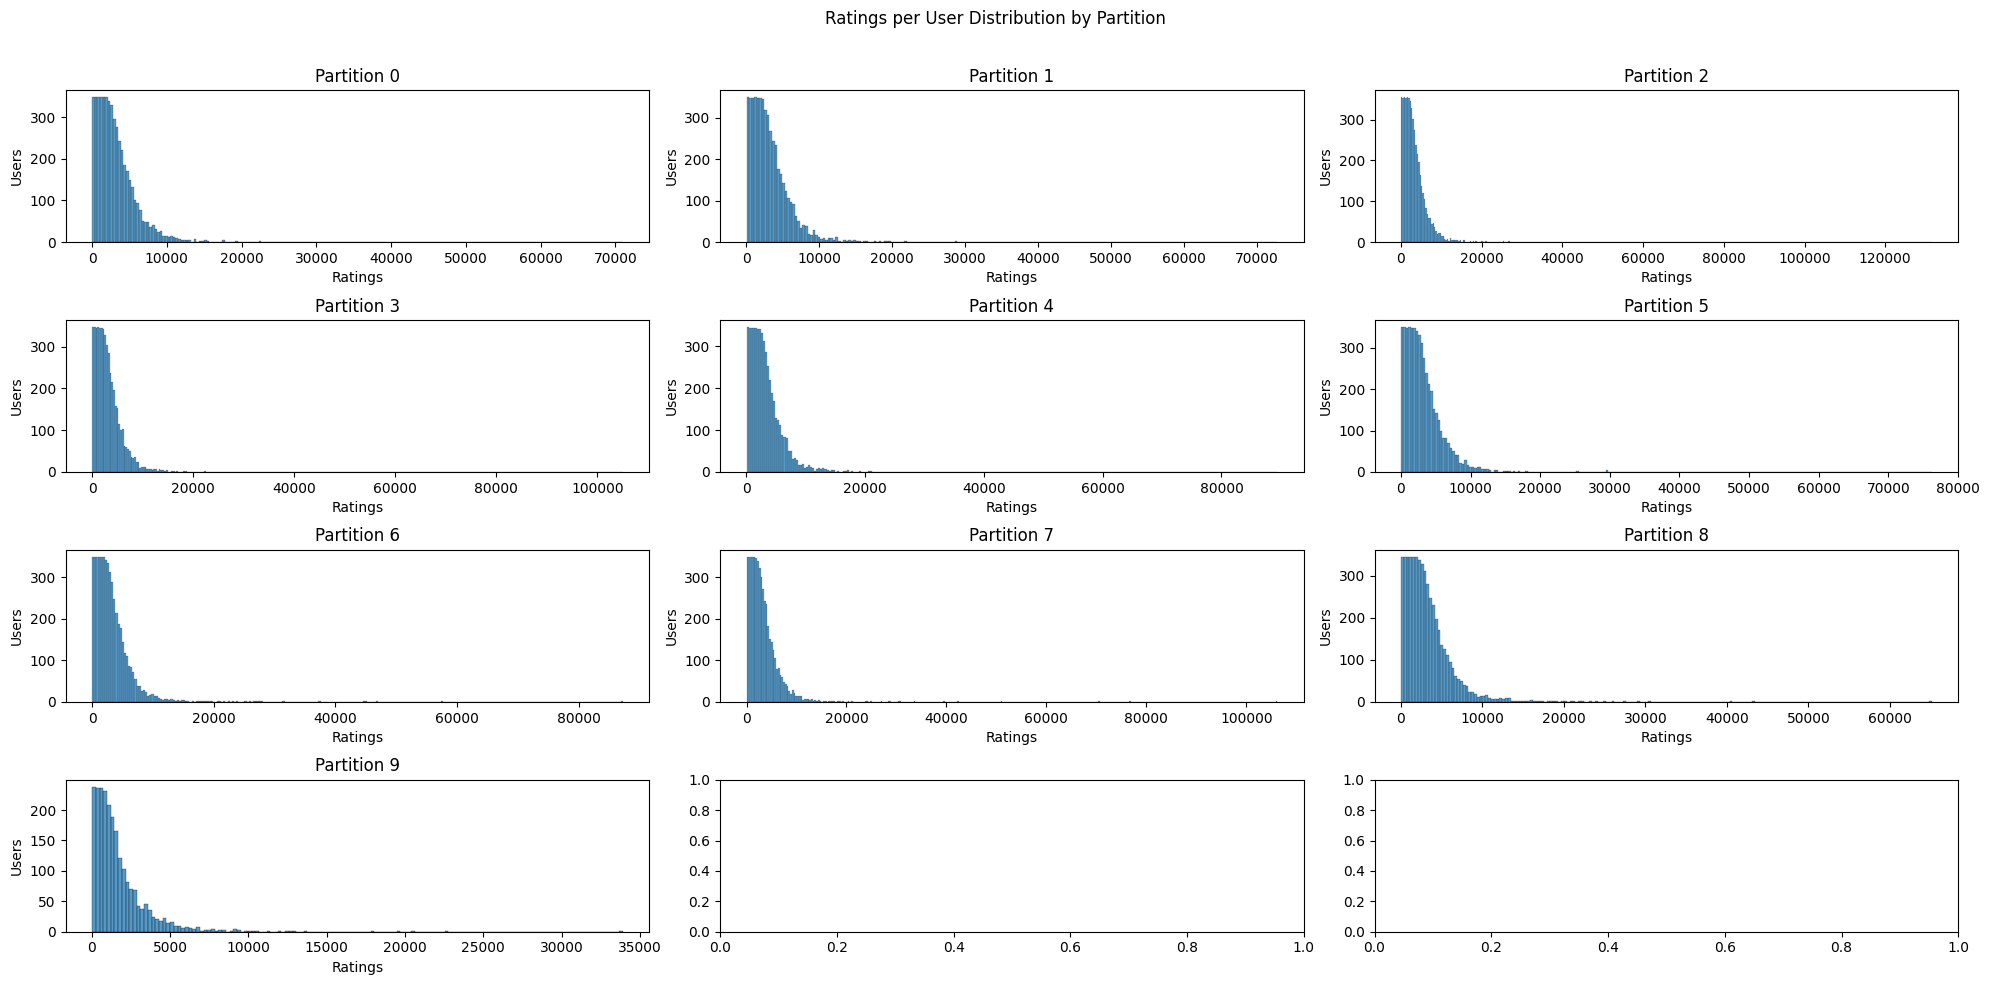

In [9]:
# plot_partitions = [i for i in range(partitions)]
maxCols = 3
rows = (partitions // maxCols) + 1

# Plot ratings per user distribution for each partition
fig, ax = plt.subplots(rows, maxCols, figsize=(20, 10))
fig.suptitle(f"Ratings per User Distribution by Partition")
for i in range(partitions):
    train_data_partition = train_data.filter(F.col("partition_id") == i)
    row = i // maxCols
    col = i % maxCols
    histplot_user_ratings_distribution(train_data_partition, ax=ax[row, col], partition=i)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## Rating Score Distribution

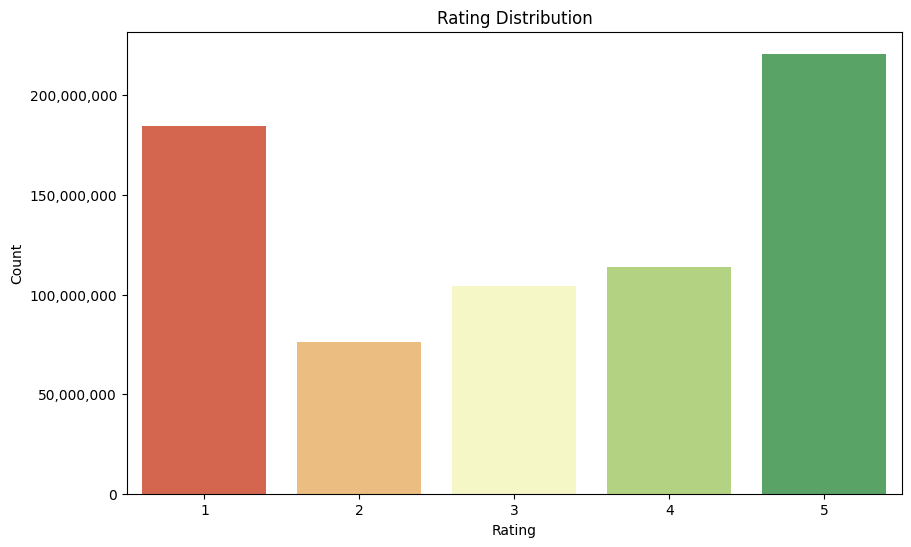

In [10]:
# Plot the distribution of rating scores
barplot_rating_distribution(train_data)

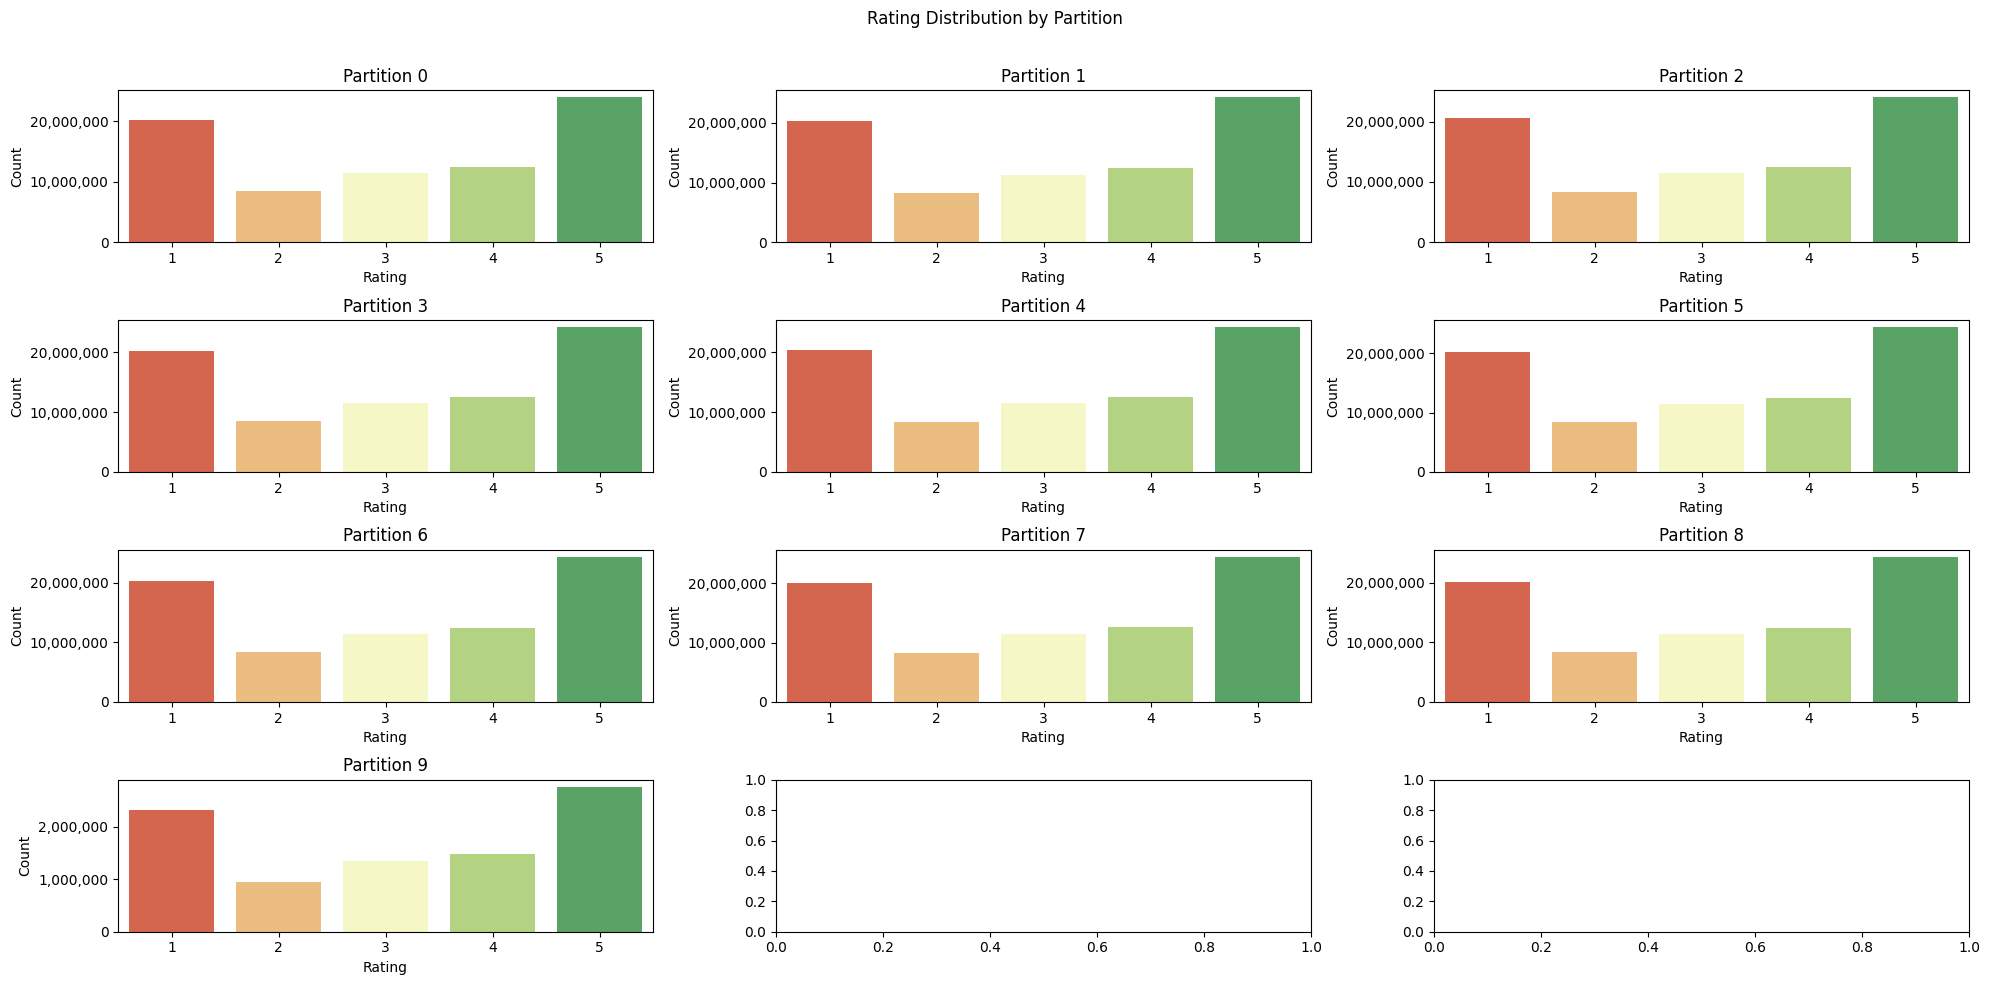

In [11]:
# Plot the distribution of rating scores for each partition
fig, ax = plt.subplots(rows, maxCols, figsize=(20, 10))
fig.suptitle(f"Rating Distribution by Partition")
for i in range(partitions):
    train_data_partition = train_data.filter(F.col("partition_id") == i)
    row = i // maxCols
    col = i % maxCols
    barplot_rating_distribution(train_data_partition, ax=ax[row, col], partition=i)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [10]:
spark.stop()